In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from collections import defaultdict

class KMeans:
    
    def __init__(self, k):
        self.k = k
        
    def fit(self, data, kpp=False, n_iters=10000, eps=10**-6, print_iter=True):
        
        def kpp_init():
            pass
        
        if kpp:
            self.centroids = kpp_init()
        else:
            centr_ind = np.random.choice(range(data.shape[0]), size=self.k)
            self.centroids = data[centr_ind, :]
        
        for _iter in range(n_iters):
            
            norm_mat = np.power(distance_matrix(data, self.centroids), 2)
            self.current_clusters = np.argmin(norm_mat, axis=1)
            new_centroids = np.array([np.mean(data[self.current_clusters==i, :], axis=0)
                                      for i in range(self.k)])
            delta = abs(np.mean(self.centroids - new_centroids))
            self.centroids = new_centroids
            if delta <= eps:
                if print_iter: print(f'Converged in {_iter} iterations')
                break
    
    def fit_predict(self, data, kpp=False, n_iters=10000, eps=10**-6, print_iter=True):
        self.fit(data, kpp, n_iters, eps, print_iter)
        return self.current_clusters
    
class DBSCAN:
    
    def __init__(self, eps, m):
        self.eps = eps
        self.m = m
    
    def fit(self, data):
        
        # Finding core samples and their neighbors
        dist_arr = distance_matrix(data, data)
        self.core_samples = []
        self.inv_dic = {k: None for k in range(data.shape[0])}
        
        for i in range(data.shape[0]):
            neighbors = [x[0] for x in np.argwhere(dist_arr[i, :] <= self.eps)]
            if len(neighbors) >= self.m:
                self.core_samples.append(i)
                for neighbor in neighbors:
                    if self.inv_dic[neighbor] == None: self.inv_dic[neighbor] = i
        
        # Finding connected components 
        adj_mat = csr_matrix(dist_arr[np.ix_(self.core_samples, self.core_samples)] <= self.eps)
        self.n_comp, self.labs = connected_components(adj_mat, directed=False)
        
        # Setting up chain of references
        
        self.component_dic = {k: self.labs[i] for i, k in enumerate(self.core_samples)}
        #self.inv_dic = {v: k for k, v in self.core_samples.items()}
        self.clusters = np.full(data.shape[0], None)
        
        for i in range(data.shape[0]):
            if self.inv_dic[i] != None:
                self.clusters[i] = self.component_dic[self.inv_dic[i]]
            else:
                self.clusters[i] = -1
                
    def fit_predict(self, data):
        self.fit(data)
        return self.clusters

#Agglomerative Clustering, average linkage

class Agglomerative_Clustering:
    
    def __init__(self):
        self.Tree = nx.DiGraph()
        
    def avg_link(self):
        min_val = np.Inf
        min_pair = None
        for i, el1 in enumerate(self.roots):
            for el2 in self.roots[i+1:]:
                el1_elems = self.Tree.node[el1]['elems']
                el2_elems = self.Tree.node[el2]['elems']
                mean_dist = np.mean(self.distance_mat[np.ix_(el1_elems, el2_elems)])
                if mean_dist < min_val:
                    min_val = mean_dist
                    min_pair = (el1, el2)
        return min_pair
        
    def fit(self, data):
        self.roots = list(np.arange(data.shape[0]))
        self.Tree.add_nodes_from(zip(self.roots, 
                                     [{'elems': [x]} for x in self.roots]))
        self.last_i = data.shape[0]
        self.distance_mat = distance_matrix(data, data)
        
        for _ in tqdm_notebook(range(data.shape[0] - 1)):
            el1, el2 = self.avg_link()
            merged = self.Tree.node[el1]['elems']+self.Tree.node[el2]['elems']
            self.Tree.add_node(self.last_i, elems=merged)
            self.Tree.add_edges_from(zip([self.last_i]*2, [el1, el2]))
            self.roots.remove(el1)
            self.roots.remove(el2)
            self.roots.append(self.last_i)
            self.last_i += 1
            
        assert(nx.number_weakly_connected_components(self.Tree) == 1)
        
    def predict(self, data, k):
        
        def rec_check(n):
            if n >= self.lim:
                children = list(self.Tree.successors(n))
                assert(len(children) == 2)
                rec_check(children[0])
                rec_check(children[1])
            else:
                self.clusters.append(self.Tree.node[n]['elems'])
                
        self.lim  = self.last_i - 1 - k + 2
        self.clusters = []
        rec_check(self.last_i - 1)
        self.preds = np.full(data.shape[0], -1)
        for i, c in enumerate(self.clusters):
            self.preds[c] = i
        return self.preds
        
        
    def fit_predict(self, data, k):
        self.fit(data)
        _ = self.predict(data, k)
        return self.preds

def purity(labels, clusters):
    
    '''This function works only with non-negative class labels due to the way np.bincount() works'''
    
    from collections import defaultdict
    counts = defaultdict(list)
    for lab, c_lab,  in zip(labels, clusters):
        counts[c_lab].append(lab)
    purity_dic = {k: np.max(np.bincount(v))/len(v)  for k, v in counts.items()}
    mean_purity = np.mean([np.max(np.bincount(v))/len(v) for _, v in counts.items()])
    return purity_dic, mean_purity

def dunn_index(data, preds):
    dmat = distance_matrix(data, data)
    clusters = np.unique(preds)
    clusters = clusters[clusters != -1]
    centroids = []
    deltas = []
    for c in clusters:
        centroid = data[preds == c, :].mean(axis=0)
        centroids.append(centroid)
        cdist = dmat[np.ix_(preds == c, preds == c)]
        deltas.append(np.max(cdist))
    centr_dists = distance_matrix(np.array(centroids), np.array(centroids))
    np.fill_diagonal(centr_dists, np.Inf)
    return np.min(centr_dists)/np.max(deltas)

In [278]:
df_blobs = pd.read_csv('Data/blobs.csv')
df_blobs.head()

,X,Y
0,-0.727696,1.403000
1,-1.875566,0.589247
2,-0.891047,-1.399924
3,-0.224115,0.868289
4,-0.465409,0.306718


X_mean = -0.29; X_var = 0.884
Y_mean = 0.224; Y_var = 0.869


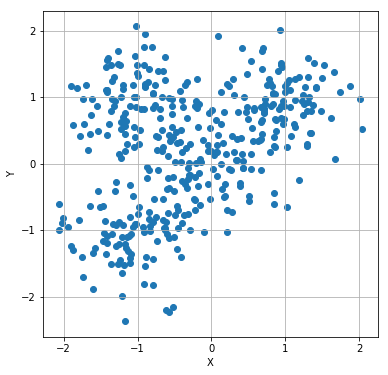

In [279]:
fig, ax = plt.subplots(figsize = [6, 6])
ax.scatter(df_blobs['X'], df_blobs['Y'])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
print('X_mean = {}; X_var = {}\nY_mean = {}; Y_var = {}'\
           .format(*map(lambda x: round(x, 3), [df_blobs['X'].mean(), df_blobs['X'].var(), 
                             df_blobs['Y'].mean(), df_blobs['Y'].var()])))

Let's standartize the data before clustering.

In [280]:
scaler = StandardScaler()
tfd_blobs = scaler.fit_transform(df_blobs.values)

X_mean = -0.0; X_var = 1.0
Y_mean = 0.0; Y_var = 1.0


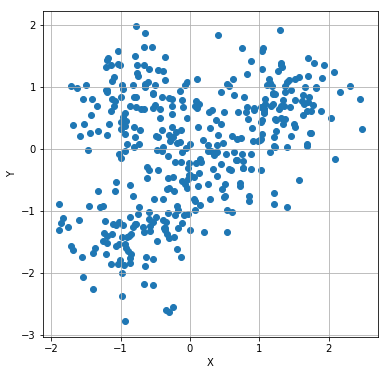

In [281]:
fig, ax = plt.subplots(figsize = [6, 6])
ax.scatter(tfd_blobs[:, 0], tfd_blobs[:, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
print('X_mean = {}; X_var = {}\nY_mean = {}; Y_var = {}'\
           .format(*map(lambda x: round(x, 3), [np.mean(tfd_blobs[:, 0]), np.var(tfd_blobs[:, 0]), 
                            np.mean(tfd_blobs[:, 1]), np.var(tfd_blobs[:, 1])])))

# K-Means algorithm

In [282]:
k_range = range(2, 6)
preds_arr = []
centroids_arr = []
for k in k_range:
    model = KMeans(k)
    preds = model.fit_predict(tfd_blobs)
    preds_arr.append(preds)
    centroids_arr.append(model.centroids)

Converged in 8 iterations
Converged in 8 iterations
Converged in 13 iterations
Converged in 10 iterations


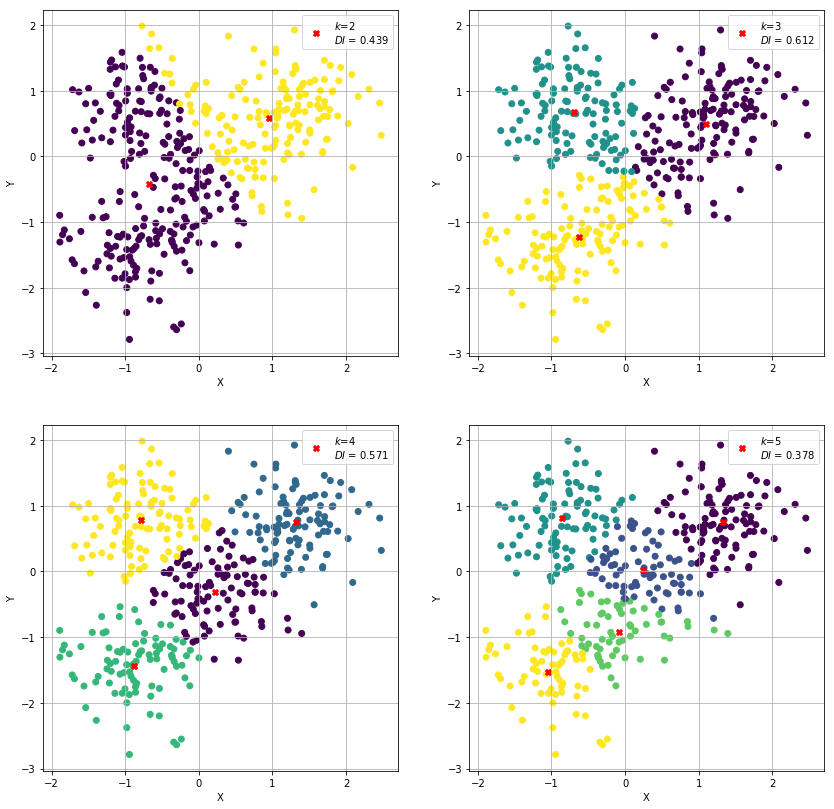

In [284]:
fig, ax_arr = plt.subplots(len(k_range)//2, 2, figsize=[14, 14])
for i, k in enumerate(k_range):
    curr_ax = ax_arr[i//2][i%2]
    DI = np.round(dunn_index(tfd_blobs, preds_arr[i]), 3)
    curr_ax.scatter(tfd_blobs[:, 0], tfd_blobs[:, 1], c=preds_arr[i])
    curr_ax.scatter(centroids_arr[i][:, 0], centroids_arr[i][:, 1], color='red', marker='X', 
                    label=f'$k$={k}\n$DI$ = {DI}')
    curr_ax.legend()
    curr_ax.grid()
    curr_ax.set_xlabel('X')
    curr_ax.set_ylabel('Y')

# DBSCAN

In [285]:
model = DBSCAN(0.3, 17)
db_preds = model.fit_predict(df_blobs.values)
print(f'Number of clusters = {model.n_comp}')

Number of clusters = 4


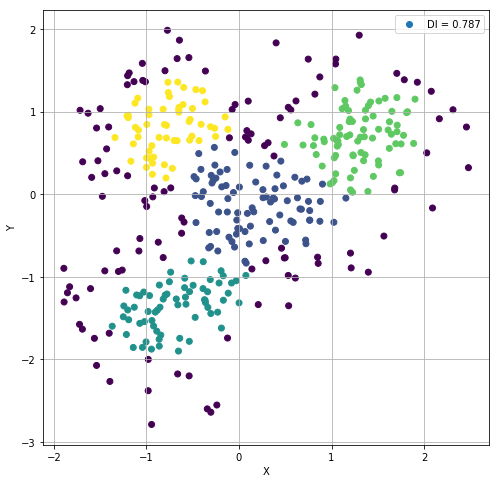

In [288]:
fig, ax = plt.subplots(figsize = [8, 8])
DI = np.round(dunn_index(tfd_blobs, db_preds), 3)
ax.scatter(tfd_blobs[:, 0], tfd_blobs[:, 1], c=db_preds, label=f'DI = {DI}')
ax.set_xlabel('X')
ax.legend()
ax.set_ylabel('Y')
ax.grid()

# Agglomerative clustering

In [249]:
model = Agglomerative_Clustering()
model.fit(tfd_blobs)

HBox(children=(IntProgress(value=0, max=399), HTML(value='')))

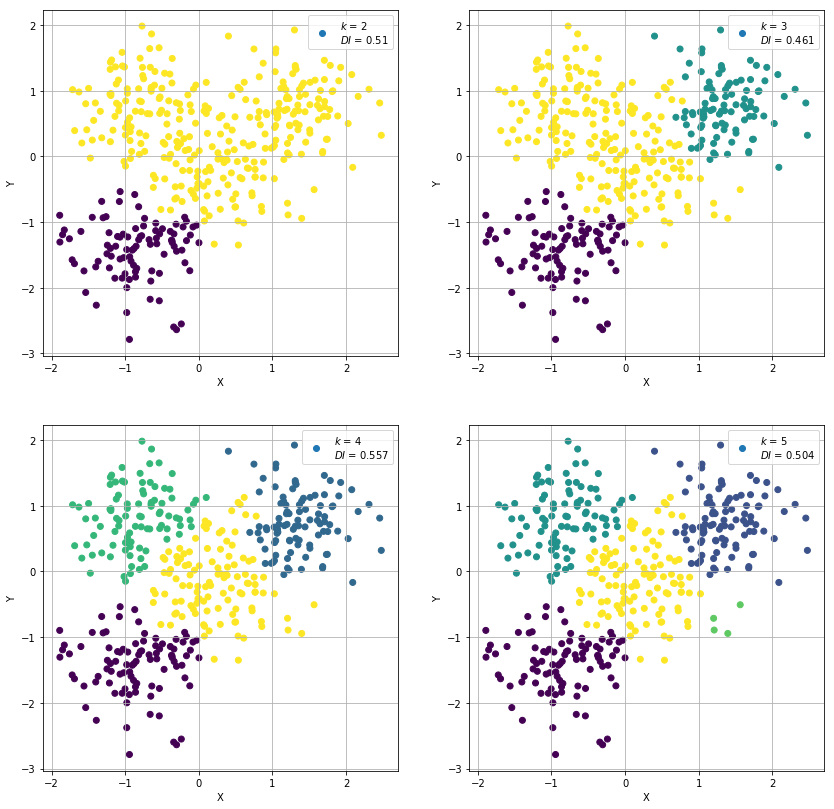

In [276]:
k_range = range(2, 6)
fig, ax_arr = plt.subplots(len(k_range)//2, 2, figsize=[14, 14])
for i, k in enumerate(k_range):
    curr_ax = ax_arr[i//2][i%2]
    preds = model.predict(tfd_blobs, k)
    DI = np.round(dunn_index(tfd_blobs, preds), 3)
    curr_ax.scatter(tfd_blobs[:, 0], tfd_blobs[:, 1], c = preds, label = f'$k$ = {k}\n$DI$ = {DI}')
    curr_ax.legend()
    curr_ax.grid()
    curr_ax.set_xlabel('X')
    curr_ax.set_ylabel('Y')

# Purity on K-Means clusters

In [13]:
df_cancer = pd.read_csv('Data/cancer.csv')
df_cancer['label'], enc = pd.factorize(df_cancer['label'])
print('Encoding: {}'.format(enc))
df_cancer.head()

Encoding: Index(['M', 'B'], dtype='object')


,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [14]:
labels = df_cancer['label']
features = df_cancer.drop(columns='label')

In [78]:
k_range = range(2, 11)
for k in k_range:
    model = KMeans(k)
    preds = model.fit_predict(features.values, print_iter=False)
    print("k = {}; purity = {}".format(k, purity(labels, preds)[1]))

k = 2; purity = 0.9025759001707971
k = 3; purity = 0.9413069544364508
k = 4; purity = 0.8717619916935209
k = 5; purity = 0.9279708464941626
k = 6; purity = 0.9116212302252782
k = 7; purity = 0.9112576410107086
k = 8; purity = 0.9206091216430559
k = 9; purity = 0.9321350189022041
k = 10; purity = 0.9139681238349473


Now let's standartize the data:

In [62]:
tfd_features = scaler.fit_transform(features)

In [65]:
k_range = range(2, 11)
for k in k_range:
    model = KMeans(k)
    preds = model.fit_predict(tfd_features, print_iter=False)
    print("k = {}; purity = {}".format(k, purity(labels, preds)[1]))

k = 2; purity = 0.9056082474226804
k = 3; purity = 0.8426107641986323
k = 4; purity = 0.7887304482087314
k = 5; purity = 0.8950549634273773
k = 6; purity = 0.9227197254663623
k = 7; purity = 0.9403537121491842
k = 8; purity = 0.9104399942578237
k = 9; purity = 0.9242304555292244
k = 10; purity = 0.9280137846909252
